In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from dfmodel import DigitalFamilyBinary

In [2]:
training_data = pd.read_csv(
    "../tests/data/design_matrix_train.tsv",
    sep="\t"
)

In [3]:
testing_data = pd.read_csv(
    "../tests/data/design_matrix_test.tsv",
    sep="\t"
)

In [4]:
clinical_columns = [
    "sao2_ambulance",
    "resp_frequency_ambulance",
    "heart_rate_ambulance",
    "syst_bp_ambulance",
    "map_ambulance",
    "mental_status_ambulance",
    "temperature_ambulance",
    "crea_emergency_department",
    "bili_emergency_department",
    "crp_day1",
    "trc_emergency_department",
    "sex",
    "age"
]

continuous_clinical_columns = [
    "sao2_ambulance",
    "resp_frequency_ambulance",
    "heart_rate_ambulance",
    "syst_bp_ambulance",
    "map_ambulance",
    "temperature_ambulance",
    "crea_emergency_department",
    "bili_emergency_department",
    "trc_emergency_department",
    "crp_day1",
    "age"
]

categorical_clinical_columns = [
    "mental_status_ambulance",
]

In [5]:
clinical_scaler = StandardScaler()

clinical_imputer = SimpleImputer()
constant_imputer = SimpleImputer(strategy="constant", fill_value=0.0)

training_data[continuous_clinical_columns] = clinical_imputer.fit_transform(training_data[continuous_clinical_columns])
training_data[categorical_clinical_columns] = constant_imputer.fit_transform(training_data[categorical_clinical_columns])

training_data[continuous_clinical_columns] = clinical_scaler.fit_transform(training_data[continuous_clinical_columns])


testing_data[continuous_clinical_columns] = clinical_imputer.transform(testing_data[continuous_clinical_columns])
testing_data[categorical_clinical_columns] = constant_imputer.transform(testing_data[categorical_clinical_columns])

testing_data[continuous_clinical_columns] = clinical_scaler.transform(testing_data[continuous_clinical_columns])


In [6]:
df_estimator = DigitalFamilyBinary()

In [7]:
df_estimator.fit(training_data)

In [8]:
testing_data['mean_sepsis_probability'] = df_estimator.predict(testing_data, feature_columns=clinical_columns, target_column='sepsis_or_septic_shock')

In [9]:
from scipy import stats
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

def plot_results(X_input, bootstrap_columns):

    bootstrap_counts = []


    for bootstrap_iteration in bootstrap_columns:


        mort_range = X_input[bootstrap_iteration].unique()
        mort_range.sort()
        actual_mort = []
        #mort_range = mort_range[:-1]
        counts_per_bin = []
        for val in mort_range:

            counts = X_input[X_input[bootstrap_iteration] == val]['sepsis_or_septic_shock'].value_counts()
            actual_mort.append(counts.get(1, 0) / (counts.get(0, 0) + counts.get(1, 0)))
            counts_per_bin.append(counts.sum())

        estimated_mort = pd.DataFrame(
            {
                "Actual Sepsis Rate": actual_mort,
                "Estimated Sepsis Rate": mort_range,
                "Counts": counts_per_bin
            }
        )

        bootstrap_counts.append(estimated_mort)

    estimated_sepsis = pd.concat(bootstrap_counts)

    # linreg = LinearRegression()

    # linreg.fit(estimated_sepsis[['Estimated Sepsis Rate']], estimated_sepsis[['Actual Sepsis Rate']])

    linregress_results = linregress(estimated_sepsis[['Estimated Sepsis Rate']].values.ravel(), estimated_sepsis[['Actual Sepsis Rate']].values.ravel())

    predictions = linregress_results.intercept + linregress_results.slope*estimated_sepsis[['Estimated Sepsis Rate']].values.ravel()

    corr, pval = pearsonr(
        estimated_sepsis[['Estimated Sepsis Rate']].values.ravel(), estimated_sepsis[['Actual Sepsis Rate']].values.ravel()
    )

    return estimated_sepsis, linregress_results, predictions, corr, pval

In [10]:
combined_results = pd.concat([testing_data,  df_estimator.bootstrap_results_df], axis=1)

In [11]:
estimated_sepsis, linregress_results, predictions, corr, pval = plot_results(combined_results, df_estimator.bootstrap_columns)


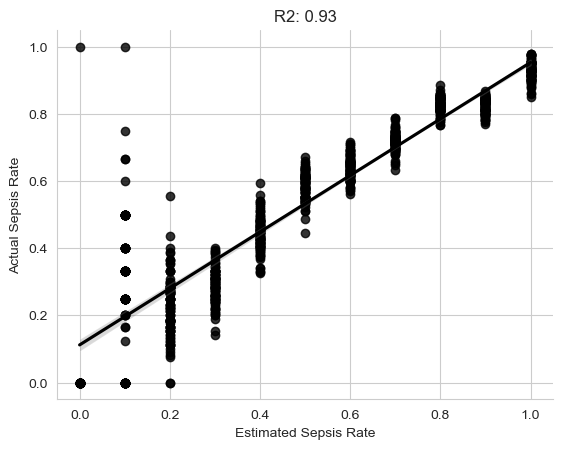

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

sns.regplot(
    data=estimated_sepsis,
    x="Estimated Sepsis Rate",
    y="Actual Sepsis Rate",
    ax=ax,
    color="k"
)

ax.set_title(
    f"R2: {linregress_results.rvalue:.2f}"
)

sns.despine()